$\newcommand{\n}[1]{\|#1 \|}$
$\renewcommand{\a}{\alpha}$
$\renewcommand{\b}{\beta}$
$\renewcommand{\c}{\gamma}$
$\renewcommand{\d}{\delta}$
$\newcommand{\la}{\lambda}$
$\newcommand{\e}{\varepsilon}$
$\renewcommand{\t}{\tau}$
$\renewcommand{\th}{\theta}$
$\newcommand{\s}{\sigma}$
$\newcommand{\x}{\bar x}$
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\DeclareMathOperator{\diag}{diag}$
$\DeclareMathOperator{\sign}{sign}$

## **Robust regression --- Mirror descent** 

If you have any questions you can additionally look at [this link](https://web.stanford.edu/class/cs229t/2017/Lectures/mirror-descent.pdf).

*Regression*: we have a sequence of vectors $a_i\in \R^n$ and measurements $b_i\in \R$ for $i=1,\dots, m$. 
We want to predict $b_i$ using $\lr{a_i, x}$ for some unknown $x\in \R^n$. 

Because of possible outliers (or other reasons) $\ell_2$-regression may be not a good choice, we want a more robust approach. 

Given $A\in \R^{m\times n}$ and $b\in \R^m$, minimize
$$ f(x) = \frac{1}{m} \n{Ax-b}_1  = \frac{1}{m}\sum_{i=1}^m |\lr{a_i,x} - b_i|$$


First, answer the following questions:

 - Is the problem convex?
 - Is the problem smooth / constrained?
 - What are the dimensions?
 


#### **Computing the subgradient**
 What is the subgradient of $f$ at $x$? For $y\mapsto \n{y}_1$ it is $\sign(y)$ (at zero any value from $[-1,1]$ will work). Thus,
 $$g(x) = \frac{1}{m} A^\top \sign(Ax-b) = \frac{1}{m} \sum_{i=1}^m a_i \sign(\lr{a_i,x} -b_i)$$
 
#### **Computing the stochastic subgradient**
 What is the stochastic subgradient of $f$ at $x$? One option is to take
 $$g_i(x) = a_i \sign(\lr{a_i, x} -b_i)$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from sklearn.datasets import make_regression
import datetime

In [4]:
def objective(A, b, x):
    return np.sum(np.absolute(A @ x - b))/b.shape[0]

In [5]:
def subgradient(A, b, x):
    return 1/b.shape[0] * A.T @ np.sign(A @ x - b)

def stochastic_subgradient(A, b, x, i):
    return A[i] * np.sign(A[i] @ x - b[i])


In the lecture we have seen that when we pick the negative entropy $x\log(x)$ as distance generating function for the Bregman distance, then the mirror descent update becomes
$$
x_{k+1} = x_k e^{-\alpha \nabla f(x_k)}
$$
and is therefore sometimes referred to as *exponential gradient*, or *entropic mirror descent* or *entropic descent*.

In [6]:
def entropic_md_update(x, lr, grad):
    """a.k.a. Mirror descent with respect the Bregman distance generated by the negative entropy"""
    return x * np.exp(-lr * grad)

To enforce the unit simplex constraint the corresponding **Bregman projection** $\Pi_h$ (a concept we haven't discussed but should be easy to understand) is given simply by normalizing the input (w.r.t. the $1$-norm), i.e.
$$
  \Pi_h(x) = \frac{x}{\lVert x \rVert_1}.
$$

In [7]:
def bregman_projection_onto_simplex(x):
    return x / np.linalg.norm(x, 1)

Sometimes the nomenclature is not consistent and only the method that does both - the mirror descent step, and the Bregman projection - is called *entropic mirror descent*. So for clarity we call the next function `full_entropic_md_update`.

In [8]:
def full_entropic_md_update(x, lr, grad):
    """Compute the update of one iteration of """
    y = entropic_md_update(x, lr, grad)
    x = bregman_projection_onto_simplex(y)
    return x

In [9]:
def mirror_descent(A, b, x_0, max_iters, alpha, stoch=True):
    """Run (stochastic) mirror descent method"""
    xs = [x_0]  # parameters after each update 
    objectives = []  # loss values after each update
    x = x_0
    for iteration in range(max_iters):
        if stoch == True:
            i = randint(0, len(b)-1)
            grad = stochastic_subgradient(A, b, x, i)
        else:
            grad = subgradient(A, b, x)

        # ***************************************************
        # implement (stochastic) mirror descent
        # ***************************************************   
        x = full_entropic_md_update(x, alpha, grad)
        xs.append(x)

        obj = objective(A, b, x)
        objectives.append(obj)

        if iteration % 1000 == 0:
            print("MD({bi:04d}/{ti:04d}): objective = {l:10.2f}".format(
                  bi=iteration, ti=max_iters - 1, l=obj))
    return objectives, xs

For the projected subgradient method you will need the following function which gives the projection onto the unit simplex:

In [10]:
def projection_simplex(v, z=1):
    """Projection onto unit simplex."""
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

In [11]:
def projected_sgd(A, b, x_0, max_iters, alpha, stoch=True):
    """
    Stochastic Gradient Descent with projectoin onto unit simplex
    
    :param b: numpy array of size (num_examples)
    :param A: numpy array of size (num_examples, num_features)
    :param x_0: starting parameters, a numpy array of size (num_features)
    :param max_iters: integer, number of updates to do
    
    :return:
    - objectives, a list of loss values
    - param_states, a list of parameter vectors,
    """
    xs = [x_0]  # parameters after each update 
    objectives = []  # loss values after each update
    x = x_0
    for iteration in range(max_iters):
        if stoch == True:
            i = randint(0, len(b)-1)
            grad = stochastic_subgradient(A, b, x, i)
        else:
            grad = subgradient(A, b, x)
        
        # ***************************************************
        # implement (stochastic) gradient descent + projection
        # ***************************************************
        x = x - alpha * grad
        x = projection_simplex(x)
        
        # store x and objective
        xs.append(x.copy())
        obj = objective(A, b, x)
        objectives.append(obj)

        if iteration % 1000 == 0:
            print("SGD({bi:04d}/{ti:04d}): objective = {l:10.2f}".format(
                  bi=iteration, ti=max_iters - 1, l=obj))
    return objectives, xs

## Problem setup

Compare the version of mirror descent given by the update in `full_entropic_md_update` to the projected sub-gradient method. Both for **stochastic vs deterministic** and **last iterate** vs **averaged iterates**. On the following problem:

$$
\min_{x\in \Delta^d} f(x) = \frac{1}{m} \n{Ax-b}_1
$$
where $\Delta^d = \{ x \in \R^d: x\ge 0, \n{x}_1 \le 1\}$ is the unit simplex.

In [14]:
from scipy.stats import t 
A, _, xstar = make_regression(n_samples=10000, n_features=1000, coef=True)
xstar = np.abs(xstar)/ np.linalg.norm(xstar, 1)  # make solution element of unit simplex
noise = t.rvs(df=1, size=A.shape[0])    # one degree of freedom for fat tails
b = A @ xstar + noise
best_objective = objective(A, b, xstar)
print('Number of samples n = ', b.shape[0])
print('Dimension of each sample d = ', A.shape[1])
print('Best objective', best_objective)


Number of samples n =  10000
Dimension of each sample d =  1000
Best objective 372.999728451822


initialize parameters

In [30]:
# Define the parameters of the algorithm.
max_iters = int(1e4)
alpha = 0.2   # this is totally arbitrary, try different learning rates

# Initialization
x_0 = np.ones(A.shape[1])/ A.shape[1]

## Run numerical experiments

- Compare subgradient method and mirror descent as well as stochastic subgradient method and stochastic mirror descent,

- Play also with the problem size and try and find a setting where mirror descent outperforms the standard subgradient method.

- Experiment with the dimension of the problem and compare the 2-norm and $\infty$-norm of the gradient.


run projected SGD

In [16]:
# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = projected_sgd(A, b, x_0, max_iters, alpha)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/9999): objective =     373.10
SGD(1000/9999): objective =     373.08
SGD(2000/9999): objective =     373.07
SGD(3000/9999): objective =     373.06
SGD(4000/9999): objective =     373.07
SGD(5000/9999): objective =     373.09
SGD(6000/9999): objective =     373.07
SGD(7000/9999): objective =     373.06
SGD(8000/9999): objective =     373.07
SGD(9000/9999): objective =     373.09
SGD: execution time=64.806 seconds


run mirror descent method

In [17]:
# Start stochastic mirror descent.
start_time = datetime.datetime.now()
md_objectives, sgd_xs = mirror_descent(A, b, x_0, max_iters, alpha)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("MD: execution time={t:.3f} seconds".format(t=exection_time))

MD(0000/9999): objective =     373.04
MD(1000/9999): objective =     373.01
MD(2000/9999): objective =     373.05
MD(3000/9999): objective =     373.04
MD(4000/9999): objective =     373.03
MD(5000/9999): objective =     373.09
MD(6000/9999): objective =     373.04
MD(7000/9999): objective =     373.04
MD(8000/9999): objective =     373.04
MD(9000/9999): objective =     373.10
MD: execution time=63.674 seconds


plot convergence

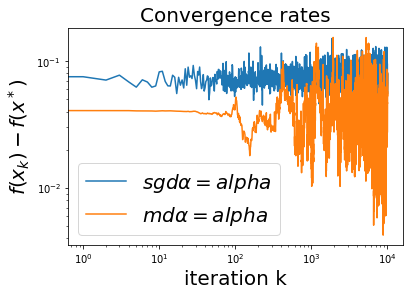

In [18]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$sgd \alpha = {alpha}$')
plt.loglog(md_objectives - best_objective, label = r'$md \alpha = {alpha}$')
plt.xlabel('iteration k'  , fontsize = 20)
plt.ylabel(r'$f(x_k) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

Compare projected subgradient descent and mirror subgradient descent

In [31]:
# Start GD.
start_time = datetime.datetime.now()
gd_objectives, gd_xs = projected_sgd(A, b, x_0, max_iters, alpha, stoch=False)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/9999): objective =     373.02
SGD(1000/9999): objective =     372.99
SGD(2000/9999): objective =     372.99
SGD(3000/9999): objective =     372.99
SGD(4000/9999): objective =     372.99
SGD(5000/9999): objective =     372.99
SGD(6000/9999): objective =     372.99
SGD(7000/9999): objective =     372.99
SGD(8000/9999): objective =     372.99
SGD(9000/9999): objective =     372.99
SGD: execution time=609.607 seconds


In [32]:
# Start mirror descent.
start_time = datetime.datetime.now()
md_objectives2, mgd_xs = mirror_descent(A, b, x_0, max_iters, alpha, stoch=False)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("MD: execution time={t:.3f} seconds".format(t=exection_time))

MD(0000/9999): objective =     373.04
MD(1000/9999): objective =     373.00
MD(2000/9999): objective =     372.99
MD(3000/9999): objective =     372.99
MD(4000/9999): objective =     372.99
MD(5000/9999): objective =     372.99
MD(6000/9999): objective =     372.99
MD(7000/9999): objective =     372.99
MD(8000/9999): objective =     372.99
MD(9000/9999): objective =     372.99
MD: execution time=595.747 seconds


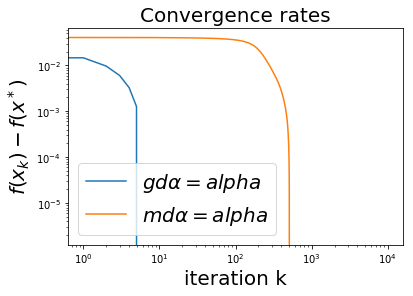

In [33]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(gd_objectives - best_objective, label = r'$gd \alpha = {alpha}$')
plt.loglog(md_objectives2 - best_objective, label = r'$md \alpha = {alpha}$')
plt.xlabel('iteration k'  , fontsize = 20)
plt.ylabel(r'$f(x_k) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

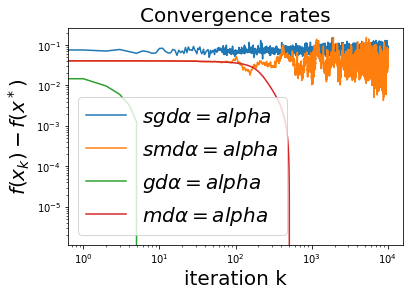

In [34]:
# Plotting all 2 methods in their stochastic and nonstochastic setting
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$sgd \alpha = {alpha}$')
plt.loglog(md_objectives - best_objective, label = r'$smd \alpha = {alpha}$')
plt.loglog(gd_objectives - best_objective, label = r'$gd \alpha = {alpha}$')
plt.loglog(md_objectives2 - best_objective, label = r'$md \alpha = {alpha}$')
plt.xlabel('iteration k'  , fontsize = 20)
plt.ylabel(r'$f(x_k) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

In [27]:
# find a setting where the mirror descent outperforms the projected gradient descent

# Define the parameters
max_iters = int(1e4)
alpha = 0.01   # set smaller alpha

# Initialization
x_0 = np.ones(A.shape[1])/ A.shape[1]

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_s, sgd_xs_s = projected_sgd(A, b, x_0, max_iters, alpha)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

# Start stochastic mirror descent.
start_time = datetime.datetime.now()
md_objectives_s, sgd_xs_s = mirror_descent(A, b, x_0, max_iters, alpha)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("MD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/9999): objective =     373.04
SGD(1000/9999): objective =     373.04
SGD(2000/9999): objective =     373.04
SGD(3000/9999): objective =     373.04
SGD(4000/9999): objective =     373.04
SGD(5000/9999): objective =     373.04
SGD(6000/9999): objective =     373.04
SGD(7000/9999): objective =     373.04
SGD(8000/9999): objective =     373.04
SGD(9000/9999): objective =     373.04
SGD: execution time=63.082 seconds
MD(0000/9999): objective =     373.04
MD(1000/9999): objective =     373.04
MD(2000/9999): objective =     373.04
MD(3000/9999): objective =     373.03
MD(4000/9999): objective =     373.03
MD(5000/9999): objective =     373.02
MD(6000/9999): objective =     373.01
MD(7000/9999): objective =     373.01
MD(8000/9999): objective =     373.00
MD(9000/9999): objective =     373.00
MD: execution time=62.028 seconds


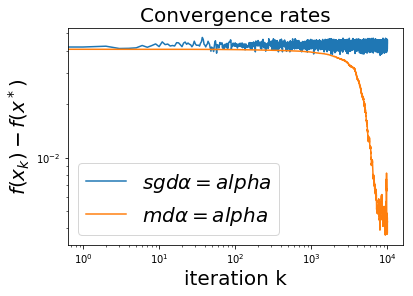

In [28]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives_s - best_objective, label = r'$sgd \alpha = {alpha}$')
plt.loglog(md_objectives_s - best_objective, label = r'$md \alpha = {alpha}$')
plt.xlabel('iteration k'  , fontsize = 20)
plt.ylabel(r'$f(x_k) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

In [ ]:
# experiment with the dimension of the problem and compare the 2-norm and  ∞ -norm of the gradient.

# larger dimensions
n = 100000
m = 10000
A, _, xstar = make_regression(n_samples=n, n_features=m, coef=True)
xstar = np.abs(xstar)/ np.linalg.norm(xstar, 1)  # make solution element of unit simplex
noise = t.rvs(df=1, size=A.shape[0])    # one degree of freedom for fat tails
b = A @ xstar + noise
best_objective = objective(A, b, xstar)
print('Number of samples n = ', b.shape[0])
print('Dimension of each sample d = ', A.shape[1])
print('Best objective', best_objective)